## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import requests

from cv2 import rectangle
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [4]:
import torch

In [5]:
import tensorflow as tf
BATCH_SIZE = 16

In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torchvision.transforms.functional import to_pil_image, to_tensor, resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
!wget "https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640" -O "img.jpg"

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/frederic.boisnard/.wget-hsts'. HSTS will be disabled.
--2025-09-05 20:22:18--  https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640
Resolving unsplash.com (unsplash.com)... 151.101.193.181, 151.101.65.181, 151.101.129.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.193.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1475266698552-c3349f5e1360?ixlib=rb-4.1.0&q=85&fm=jpg&crop=entropy&cs=srgb&dl=toa-heftiba-MXvcHk-zCIs-unsplash.jpg&w=640 [following]
--2025-09-05 20:22:19--  https://images.unsplash.com/photo-1475266698552-c3349f5e1360?ixlib=rb-4.1.0&q=85&fm=jpg&crop=entropy&cs=srgb&dl=toa-heftiba-MXvcHk-zCIs-unsplash.jpg&w=640
Resolving images.unsplash.com (images.unsplash.com)... 199.232.82.208, 2a04:4e42:54::720
Connecting to images.unsplash.com (images.unsplash.com)|19

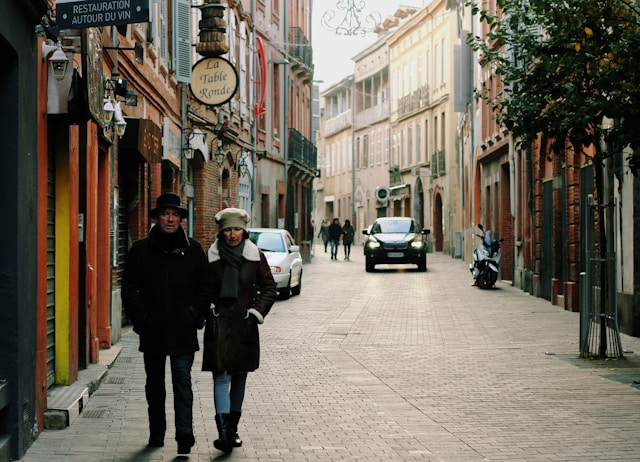

In [8]:
# street from Toulouse
url = "https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640"

# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("img.jpg")

# get a torch tensor
torch_image = to_tensor(image)

# batch the image
visualizable_torch_inputs = torch_image.unsqueeze(0)

# visualize image
to_pil_image(torch_image)

In [9]:
visualizable_torch_inputs.shape

torch.Size([1, 3, 462, 640])

## Load FCOS

In [10]:
import torchvision.transforms as T

In [11]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

nb_classes = len(CLASSES)
print(nb_classes)

91


In [12]:
# Load FCOS Model
device = 'cuda'

from torchvision.models.detection import fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights

# Step 1: Initialize model with the best available weights
weights = FCOS_ResNet50_FPN_Weights.DEFAULT
model = fcos_resnet50_fpn(weights=weights) #, box_score_thresh=0.9)
model.eval()
model = model.to(device)
print('model loaded')

model loaded


In [13]:
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
processed_torch_inputs = preprocess(visualizable_torch_inputs).to(device)

In [14]:
torch_predictions = model(processed_torch_inputs)[0]

In [15]:
torch_predictions.keys()

dict_keys(['boxes', 'scores', 'labels'])

## Obj Detection Wrapper

In [16]:
# from boxes_model_wrapper import TorchvisionBoxesModelWrapper

# od_model = TorchvisionBoxesModelWrapper(model, nb_classes=nb_classes)
# results = od_model(processed_torch_inputs)

from xplique.utils_functions.object_detection.torch.box_model_wrapper import TorchvisionBoxesModelWrapper

od_model = TorchvisionBoxesModelWrapper(model, nb_classes=nb_classes)
results = od_model(processed_torch_inputs)

In [17]:
results.shape

torch.Size([1, 99, 96])

## Visu FCOS

In [18]:
# from display_image_with_boxes import display_image_with_boxes
# from xplique.utils_functions.box_manager import BoxFormat
from xplique.plots.display_image_with_boxes import display_image_with_boxes
from xplique.utils_functions.object_detection.common.box_manager import BoxFormat

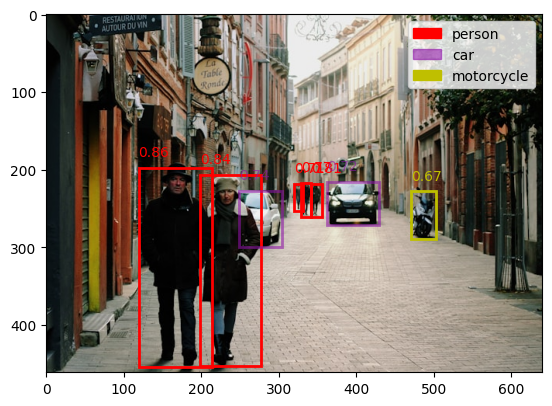

In [20]:
# class labels to color mapping
label_to_color = {'person': 'r',
                  'car': "#8F15A894",
                  'motorcycle': 'y',
                  'bicycle': 'y'}

fig = display_image_with_boxes(image, results[0].cpu().detach(), BoxFormat.XYXY, False, CLASSES, label_to_color, accuracy=0.5)

## FcosFormatter

In [ ]:
# from xplique.concepts.latent_extractor import LatentExtractor, TorchLatentExtractor, TorchvisionBoxFormatter

In [27]:
# fcos_and_formatter = T.Compose([
#     model,
#     TorchvisionBoxFormatter(nb_classes = nb_classes)
# ])
# results2 = fcos_and_formatter(visualizable_torch_inputs.to(device))
# display_image_with_boxes(image, results2[0].cpu().detach(), BoxFormat.XYXY, True, CLASSES, label_to_color, accuracy=0.9)

# Attribution

In [21]:
# Checks gradients
from xplique.utils_functions.object_detection.torch.gradients_check import check_model_gradients
check_model_gradients(od_model, processed_torch_inputs)

Gradients OK - sum=749102.500000


True

## Occlusion

In [22]:
from xplique.attributions import Saliency
from xplique.commons.operators import object_detection_operator
from xplique.wrappers import TorchWrapper

# we need to wrap our model with TorchWrapper to be able to use xplique tools with it
od_model = od_model.eval()
torch_wrapped_model = TorchWrapper(od_model, device=device, is_channel_first=True)

/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


In [30]:
# transform torch inputs to tensorflow format
tf_inputs = visualizable_torch_inputs.permute(0, 2, 3, 1)
tf_inputs = tf_inputs.detach().cpu().numpy()
targets = torch_wrapped_model(tf_inputs)

In [33]:
targets[0].shape

TensorShape([99, 96])

In [24]:
# check operation output
import xplique
operator = xplique.Tasks.OBJECT_DETECTION_BOX_PROBA
scores = operator(torch_wrapped_model, tf_inputs, targets)
print(scores)

tf.Tensor([0.37879264], shape=(1,), dtype=float32)


In [25]:
from xplique.attributions import Occlusion
explainer = Occlusion(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1, patch_size=(100, 100), patch_stride=(50, 50))

In [60]:
from xplique.utils_functions.object_detection.tf.box_manager import filter_boxes as filter_boxes_tf
box_to_explain = filter_boxes_tf(targets, class_id=CLASSES.index('person'), accuracy=0.5)
print(f"box_to_explain len: {len(box_to_explain[0])}")

box_to_explain len: 5


Number of kept annotations: 5
cl:1, Drawing box for person with color r at coords (118.83355712890625, 197.40260314941406, 213.7471923828125, 454.6330871582031) with score 0.86
cl:1, Drawing box for person with color r at coords (197.84011840820312, 206.35366821289062, 277.1688537597656, 453.7923889160156) with score 0.84
cl:1, Drawing box for person with color r at coords (341.2440185546875, 218.70333862304688, 355.04156494140625, 261.4922790527344) with score 0.81
cl:1, Drawing box for person with color r at coords (328.66119384765625, 217.5619354248047, 341.6568908691406, 261.1193542480469) with score 0.77
cl:1, Drawing box for person with color r at coords (319.1523132324219, 218.0555419921875, 330.56732177734375, 253.04165649414062) with score 0.71


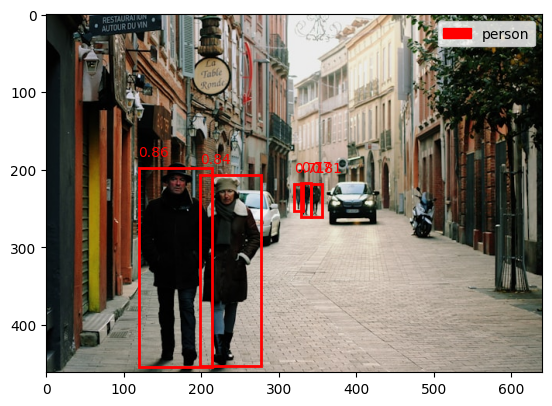

In [61]:
from xplique.plots.display_image_with_boxes import display_image_with_boxes_tf
fig = display_image_with_boxes_tf(image, box_to_explain[0], BoxFormat.XYXY, False, CLASSES, label_to_color, accuracy=0.0)

In [73]:
print(box_to_explain[0].shape)
# Add a batch dimension (dimension 0) to box_to_explain[0]
# Using tf.expand_dims which is the correct function to add a dimension at a specific axis
expanded_boxes = tf.expand_dims(box_to_explain[0], axis=0)
print(expanded_boxes.shape)

(5, 96)
(1, 5, 96)


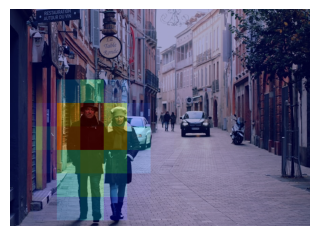

In [ ]:
from xplique.plots import plot_attributions

explanations = explainer.explain(tf_inputs, expanded_boxes[0:1, 0:1, :])
plot_attributions(explanations, tf_inputs, img_size=3.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

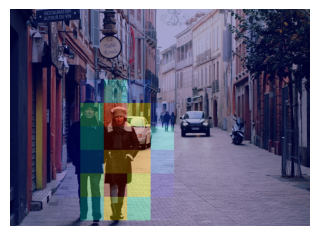

In [79]:
explanations = explainer.explain(tf_inputs, expanded_boxes[0:1, 1:2, :])
plot_attributions(explanations, tf_inputs, img_size=3.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

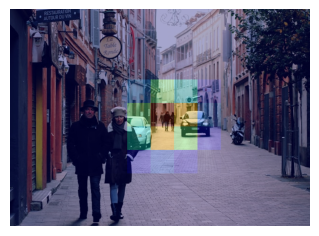

In [80]:
explanations = explainer.explain(tf_inputs, expanded_boxes[0:1, 2:3, :])
plot_attributions(explanations, tf_inputs, img_size=3.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

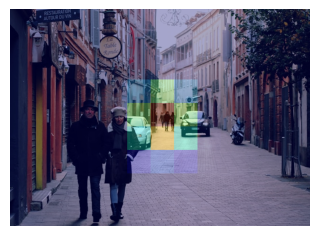

In [83]:
explanations = explainer.explain(tf_inputs, expanded_boxes[0:1, 3:4, :])
plot_attributions(explanations, tf_inputs, img_size=3.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

2025-09-05 20:52:23.325232: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


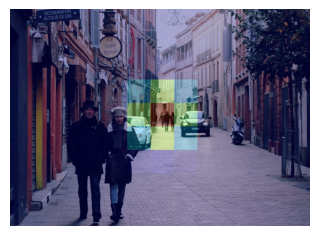

In [84]:
explanations = explainer.explain(tf_inputs, expanded_boxes[0:1, 4:5, :])
plot_attributions(explanations, tf_inputs, img_size=3.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

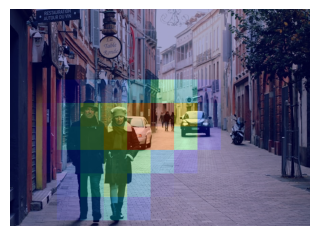

In [ ]:
# Les 3 premieres boites
explanations = explainer.explain(tf_inputs, expanded_boxes[0:1, 0:3, :])
plot_attributions(explanations, tf_inputs, img_size=3.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

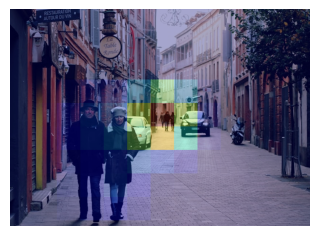

In [ ]:
# Toutes les boites
explanations = explainer.explain(tf_inputs, expanded_boxes[0:1, 0:5, :])
plot_attributions(explanations, tf_inputs, img_size=3.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

=> Pb avec occlusion où la taille des patches va targetter plutot un des sous réseaux de FCOS ?


## Saliency

In [87]:
from xplique.attributions import Saliency
from xplique.wrappers import TorchWrapper

od_model = od_model.eval()
torch_wrapped_model = TorchWrapper(od_model, device=device, is_channel_first=True)

/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


In [88]:
inputs = visualizable_torch_inputs.permute(0, 2, 3, 1)
targets = torch_wrapped_model(inputs)

In [89]:
print(f"Inputs shape: {inputs.shape}")
print(f"Targets shape: {targets.shape}")

Inputs shape: torch.Size([1, 462, 640, 3])
Targets shape: (1, 99, 96)


In [90]:
import xplique
operator = xplique.Tasks.OBJECT_DETECTION_BOX_PROBA
scores = operator(torch_wrapped_model, inputs, targets[:, 0:1,:])
print(f"final scores = {scores}")

final scores = [0.860023]


In [91]:
explainer = Saliency(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1)

In [ ]:
box_to_explain = filter_boxes_tf(targets, class_id=CLASSES.index('person'), accuracy=0.5)
print(box_to_explain[0].shape)

TensorShape([5, 96])

Saliency.expain()
inputs type: <class 'tensorflow.python.framework.ops.EagerTensor'>
inputs shape: (1, 462, 640, 3)
inputs dtype: <dtype: 'float32'>
scores type: <class 'tensorflow.python.framework.ops.EagerTensor'>
scores shape: (1,)
scores dtype: <dtype: 'float32'>
KO scores has no requires_grad
KO inputs has no requires_grad
gradients type: <class 'tensorflow.python.framework.ops.EagerTensor'>
gradients type: <class 'tensorflow.python.framework.ops.EagerTensor'>


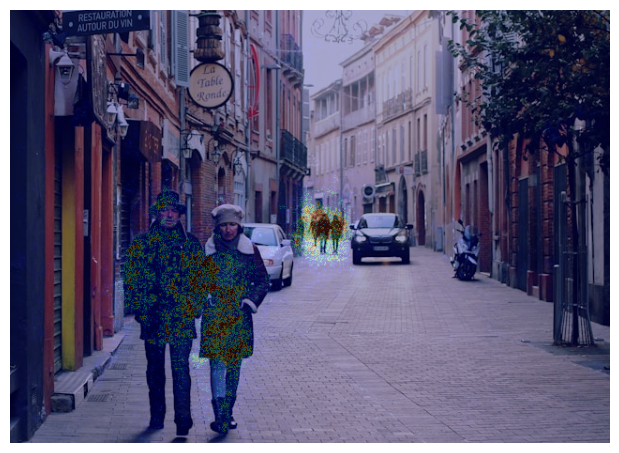

In [97]:
explanations = explainer.explain(inputs, box_to_explain)
plot_attributions(explanations, tf_inputs, img_size=6.,
                  cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)